In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [4]:
train_ds, val_ds, test_ds = load_dataset()

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель InceptionV3 без верхних слоев:

In [5]:
base_model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')

Заморозим слои, чтобы веса не обновлялись во время обучения:

In [6]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [7]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │        81,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,884,744 (83.48 MB)

 Trainable params: 81,960 (320.16 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Начнем обучение модели с замороженными нижними слоями:

In [9]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [11]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/inception_v3.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [12]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


I0000 00:00:1713770477.979602  102969 service.cc:145] XLA service 0x7704b8554bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713770477.979633  102969 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-22 14:21:18.150373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 14:21:19.547289: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  2/433 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.0000e+00 - loss: 4.1796   

I0000 00:00:1713770487.317240  102969 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 ━━━━━━━━━━━━━━━━━━━━ 65s 117ms/step - accuracy: 0.1124 - loss: 3.4389 - val_accuracy: 0.3764 - val_loss: 2.4249
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.3887 - loss: 2.3105 - val_accuracy: 0.4794 - val_loss: 1.9988
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.4783 - loss: 1.9391 - val_accuracy: 0.5138 - val_loss: 1.7911
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.5253 - loss: 1.7291 - val_accuracy: 0.5361 - val_loss: 1.6721
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.5638 - loss: 1.6015 - val_accuracy: 0.5601 - val_loss: 1.5779
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.5856 - loss: 1.4949 - val_accuracy: 0.5733 - val_loss: 1.5119
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.6012 - loss: 1.4297 - val_accuracy: 0.5881 - val_loss: 1.4587
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.6208 - loss: 1.3676 - val_accura

Так как число параметров в нижних слоях огромно (более 21 миллиона), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [13]:
results = model.evaluate(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.6634 - loss: 1.1645


In [14]:
results

[1.1905889511108398, 0.6599462628364563]

Посомтрим несколько предсказаний:

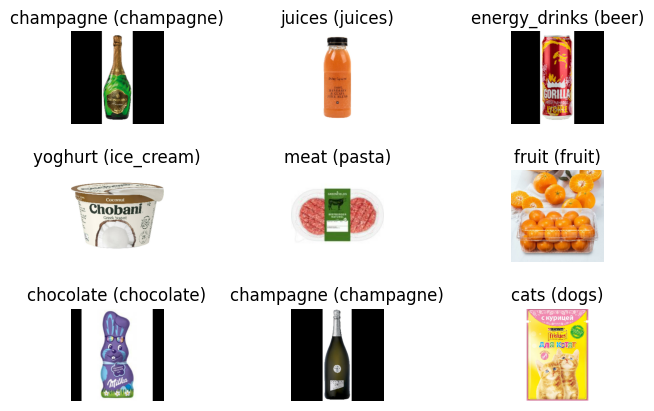

In [15]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


2024-04-22 14:36:28.599446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


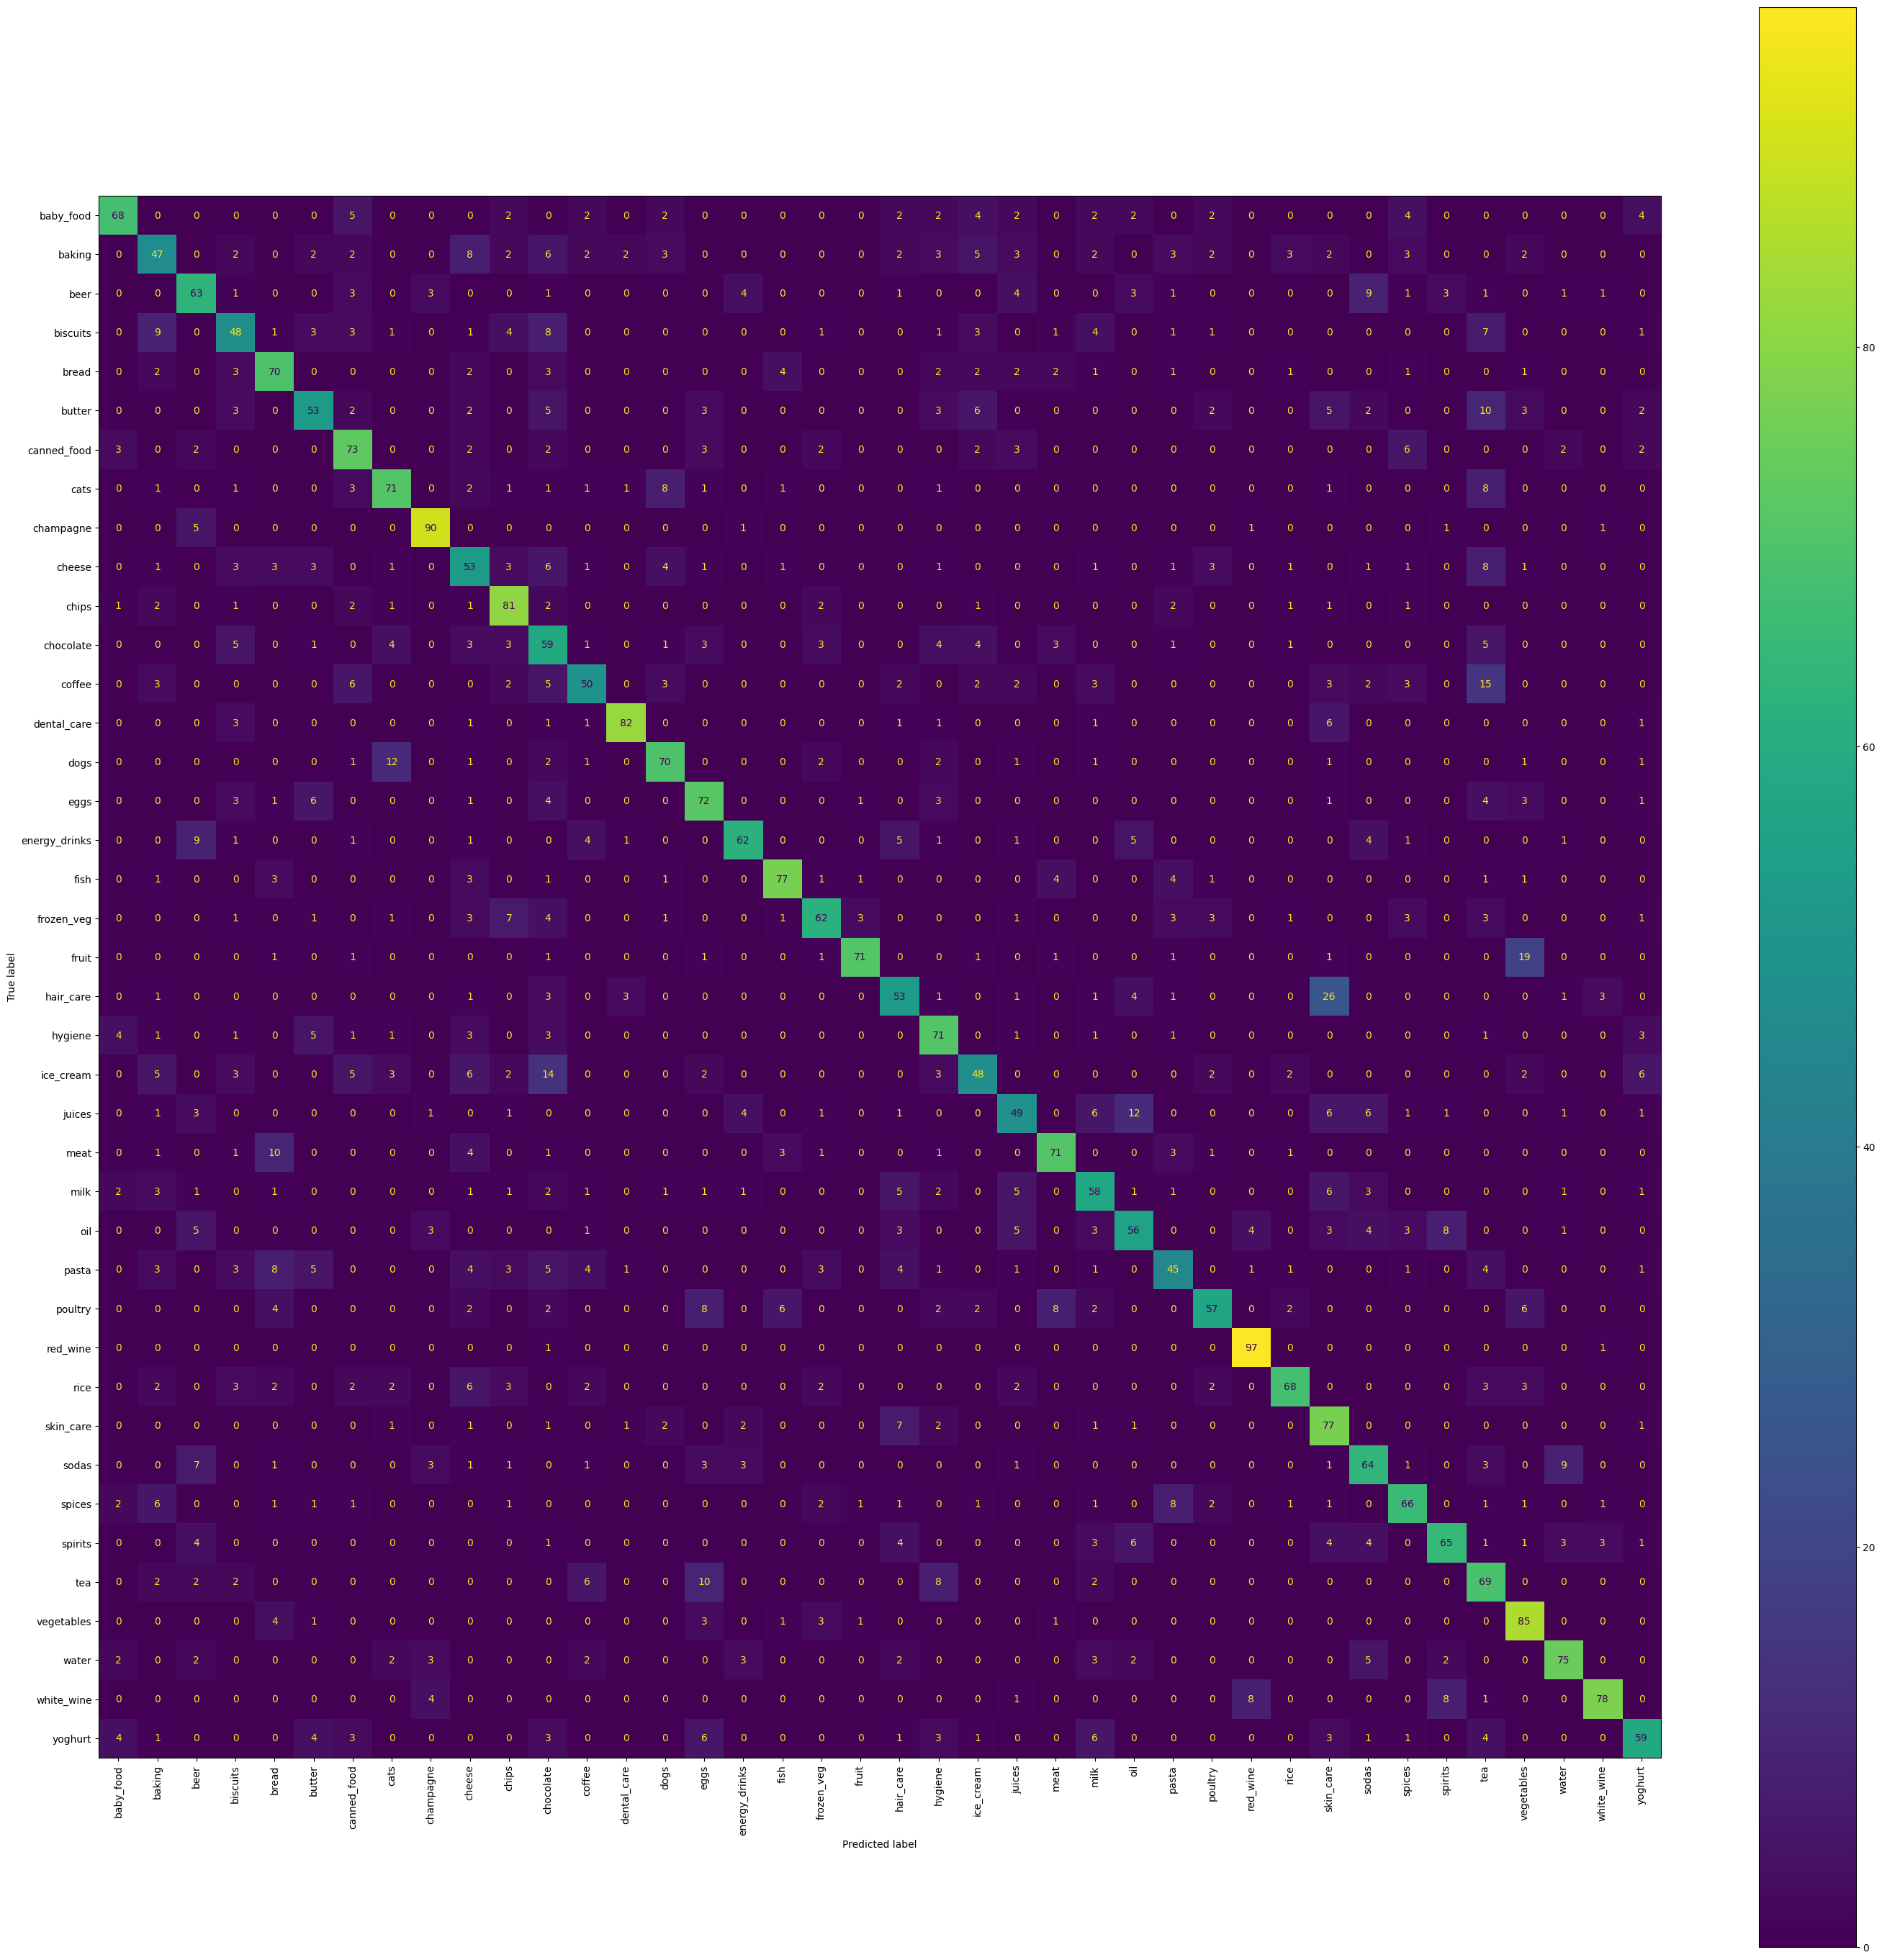

In [16]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [17]:
model.save('ready_models/inception_v3.keras')

In [18]:
import json

with open('models_histories/inception_v3.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

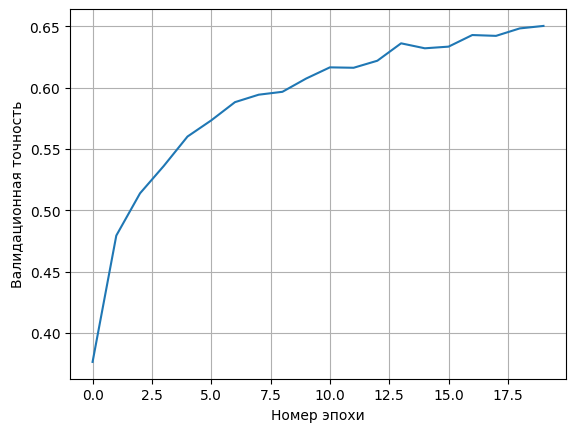

In [19]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')